In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline
sns.set_style("whitegrid")
sns.color_palette("pastel")

import warnings
from itertools import product

warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
#df = pd.read_csv('/content/drive/MyDrive/dss/air-pas.txt', sep=';', parse_dates=['Month'], index_col='Month')

In [5]:
df = pd.read_csv('/content/drive/MyDrive/dss/RATEINF-CPI_ITA.csv', parse_dates=['Date'], index_col='Date')

In [6]:
df

,Value
Date,
2021-10-31,106.6
2021-09-30,105.7
2021-08-31,104.3
2021-07-31,104.1
2021-06-30,105.2
...,...
2001-05-31,76.1
2001-04-30,75.9
2001-03-31,75.3


In [7]:
df[0:12]

,Value
Date,
2021-10-31,106.6
2021-09-30,105.7
2021-08-31,104.3
2021-07-31,104.1
2021-06-30,105.2
2021-05-31,105.0
2021-04-30,105.1
2021-03-31,104.2
2021-02-28,102.4


In [16]:
df.sort_index(inplace=True)

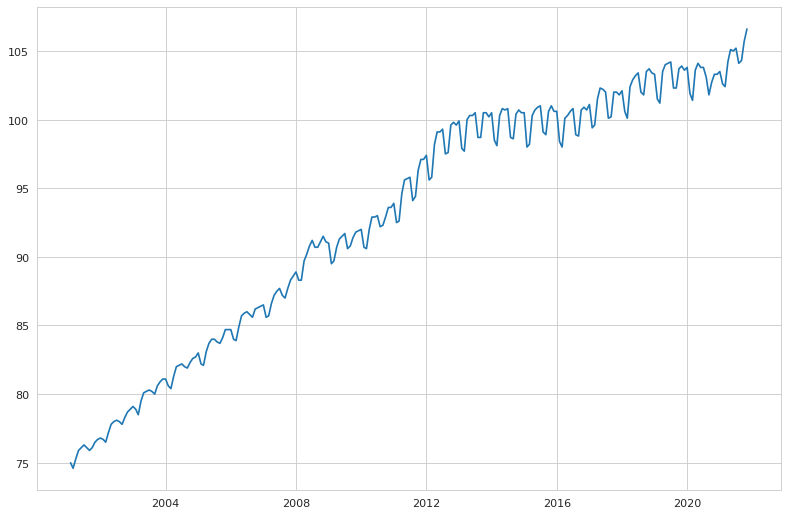

In [261]:
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(df.index, df, label='Train')

In [252]:
class HoltWinters:

    def __init__(self, series, slen, alpha, beta, gamma, n_preds):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0:
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])

                continue
            if i >= len(self.series):
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen]) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])


    def darbin_watson(self):
      d_u = sum([((df.values[i]-self.result[i])-(df.values[i-1]-self.result[i-1]))**2 \
             for i in range(len(self.series), len(self.result))])
      d_d = sum([(df.values[i]-self.result[i])**2 for i in range(len(self.series)-1, len(self.result))])
      return d_u[0] / d_d[0]


In [253]:
HW = HoltWinters(df.values[0:len(df.values)-12], 12, 0.62, 0.28, 0.65, 12)
HW.triple_exponential_smoothing()
HW.darbin_watson()

0.4489609039202408

In [254]:
# Дарбина-Уотсона для 5% уровня
dL = 0.97
dU = 1.33
print('1) '+str(dU)+' < '+str(HW.darbin_watson())+' < '+str(4-dU))
print('2) '+str(0)+' < '+str(HW.darbin_watson())+' < '+str(dL))
print('3) '+str(dL)+' < '+str(HW.darbin_watson())+' < '+str(dU))
print('   '+str(4-dU)+' < '+str(HW.darbin_watson())+' < '+str(4-dL))
print('4) '+str(4-dL)+' < '+str(HW.darbin_watson())+' < '+str(4))

1) 1.33 < 0.4489609039202408 < 2.67
2) 0 < 0.4489609039202408 < 0.97
3) 0.97 < 0.4489609039202408 < 1.33
   2.67 < 0.4489609039202408 < 3.0300000000000002
4) 3.0300000000000002 < 0.4489609039202408 < 4


In [260]:
df.index

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
               '2001-09-30', '2001-10-31',
               ...
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31'],
              dtype='datetime64[ns]', name='Date', length=250, freq=None)

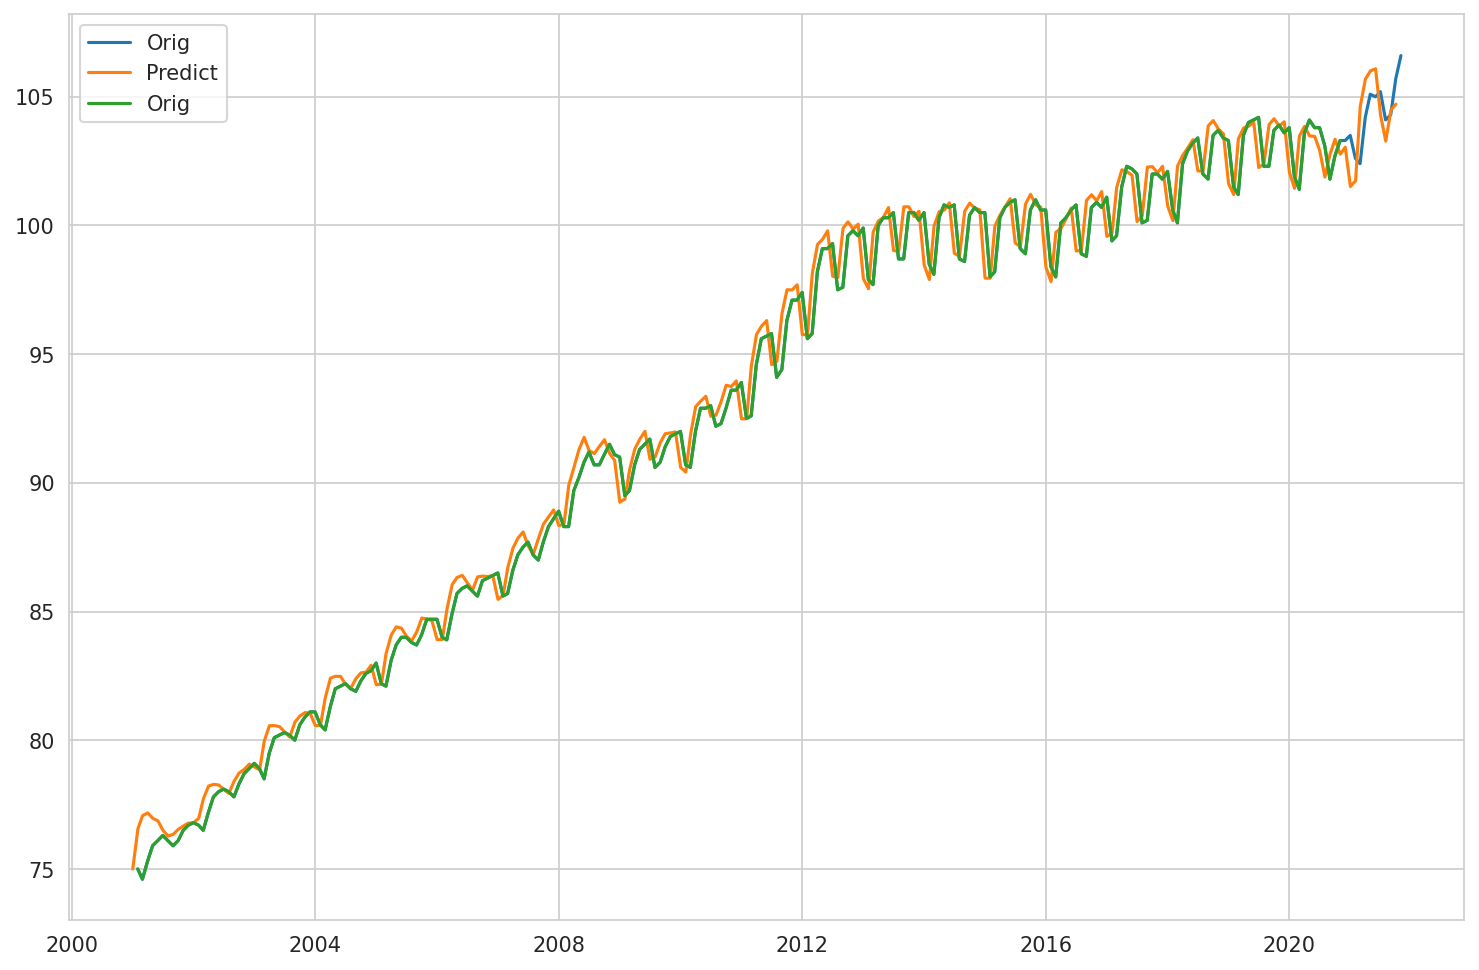

In [259]:
ind = df.index.values
ind = list(map(lambda x : np.datetime64(x, 'M'), ind))
ind_2 = [ind[len(ind)-1] + i for i in range(1, len(HW.result)-len(ind)+1)]
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(df.index, df, label='Orig')
plt.plot(ind+ind_2, HW.result, label='Predict')
plt.plot(df.index[0:len(df.values)-12], df.values[0:len(df.values)-12], label='Orig')
plt.legend()

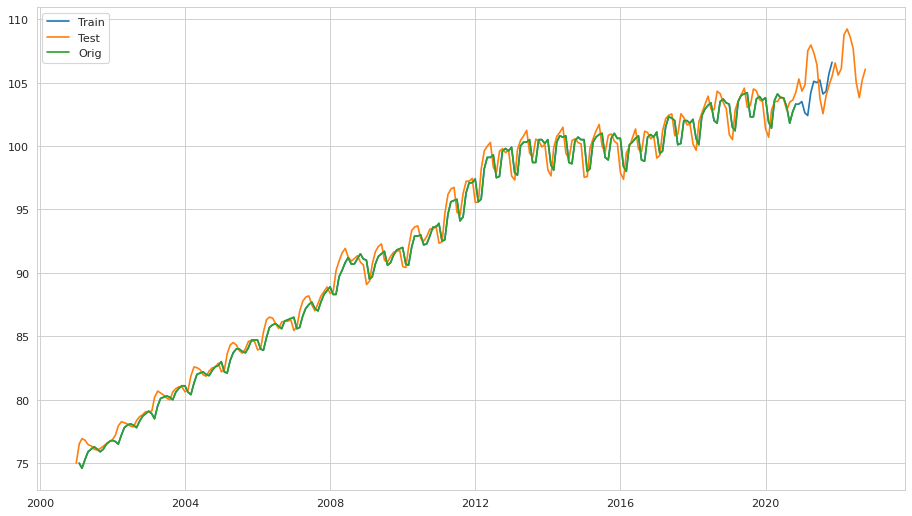